# Lab 6 — Fake News Classification with RNN and LSTM

This notebook implements and compares a **Simple RNN** and an **LSTM** on the Fake/Real News dataset.

**Important:** Place the files `Fake.csv` and `True.csv` in the **same folder** as this notebook.


In [1]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_recall_fscore_support, confusion_matrix, roc_curve, auc
import matplotlib.pyplot as plt
import seaborn as sns
import re
import time

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('Device:', device)

# ===== 1. Load data  =====
fake = pd.read_csv('./Fake.csv')  # label 1 = fake
true = pd.read_csv('./True.csv')  # label 0 = real

fake['label'] = 1
true['label'] = 0

df = pd.concat([fake, true], ignore_index=True)
df = df.sample(frac=1.0, random_state=42).reset_index(drop=True)  # shuffle

print('Total samples:', len(df))
print(df[['subject', 'label']].groupby('label').size())

# ===== 2. Text cleaning =====
def clean_text(t: str) -> str:
    t = str(t).lower()
    t = re.sub(r'[^a-z ]', ' ', t)
    t = re.sub(r'\s+', ' ', t).strip()
    return t

# Use Title + Text as recommended
df['text'] = (df['title'].fillna('') + ' ' + df['text'].fillna('')).apply(clean_text)

print('Example cleaned text:')
print(df['text'].iloc[0][:300])

Device: cpu
Total samples: 44898
label
0    21417
1    23481
dtype: int64
Example cleaned text:
ben stein calls out th circuit court committed a coup d tat against the constitution st century wire says ben stein reputable professor from pepperdine university also of some hollywood fame appearing in tv shows and films such as ferris bueller s day off made some provocative statements on judge je


In [2]:
from collections import Counter

# ===== 3. Build vocabulary =====
counter = Counter()
for t in df['text']:
    counter.update(t.split())

vocab_size = 20000  # limit to most frequent words
word2idx = {w: i + 1 for i, (w, _) in enumerate(counter.most_common(vocab_size))}
pad_idx = 0
max_len = 200

def encode(text: str):
    tokens = text.split()
    ids = [word2idx.get(w, 0) for w in tokens[:max_len]]
    if len(ids) < max_len:
        ids += [pad_idx] * (max_len - len(ids))
    return ids

encoded = np.stack([encode(t) for t in df['text']])
labels = df['label'].values.astype('int64')

X_train, X_temp, y_train, y_temp = train_test_split(
    encoded, labels, test_size=0.2, random_state=42, stratify=labels
)
X_val, X_test, y_val, y_test = train_test_split(
    X_temp, y_temp, test_size=0.5, random_state=42, stratify=y_temp
)

print('Train:', X_train.shape, 'Val:', X_val.shape, 'Test:', X_test.shape)

class NewsDataset(Dataset):
    def __init__(self, X, y):
        self.X = torch.tensor(X, dtype=torch.long)
        self.y = torch.tensor(y, dtype=torch.long)
    def __len__(self):
        return len(self.X)
    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

batch_size = 64

train_loader = DataLoader(NewsDataset(X_train, y_train), batch_size=batch_size, shuffle=True)
val_loader   = DataLoader(NewsDataset(X_val, y_val), batch_size=batch_size)
test_loader  = DataLoader(NewsDataset(X_test, y_test), batch_size=batch_size)


Train: (35918, 200) Val: (4490, 200) Test: (4490, 200)


In [3]:
class SimpleRNNClassifier(nn.Module):
    def __init__(self, vocab_size, emb_dim=100, hidden_dim=128, num_layers=1, dropout=0.2):
        super().__init__()
        self.embedding = nn.Embedding(vocab_size, emb_dim, padding_idx=pad_idx)
        self.rnn = nn.RNN(
            input_size=emb_dim,
            hidden_size=hidden_dim,
            num_layers=num_layers,
            batch_first=True,
            nonlinearity='tanh',
            dropout=(dropout if num_layers > 1 else 0.0)
        )
        self.fc = nn.Linear(hidden_dim, 1)

    def forward(self, x):
        emb = self.embedding(x)
        out, h_n = self.rnn(emb)
        last = h_n[-1]
        logits = self.fc(last).squeeze(1)
        return logits

class LSTMClassifier(nn.Module):
    def __init__(self, vocab_size, emb_dim=100, hidden_dim=128, num_layers=1, bidirectional=False, dropout=0.2):
        super().__init__()
        self.embedding = nn.Embedding(vocab_size, emb_dim, padding_idx=pad_idx)
        self.lstm = nn.LSTM(
            input_size=emb_dim,
            hidden_size=hidden_dim,
            num_layers=num_layers,
            batch_first=True,
            bidirectional=bidirectional,
            dropout=(dropout if num_layers > 1 else 0.0)
        )
        factor = 2 if bidirectional else 1
        self.fc = nn.Linear(hidden_dim * factor, 1)

    def forward(self, x):
        emb = self.embedding(x)
        out, (h_n, c_n) = self.lstm(emb)

        # Для двонапрямленої LSTM
        if self.lstm.bidirectional:
            # h_n shape: (num_layers * 2, batch, hidden_dim)
            last = torch.cat((h_n[-2], h_n[-1]), dim=1)
        else:
            last = h_n[-1]

        logits = self.fc(last).squeeze(1)
        return logits




In [4]:
def run_epoch(model, loader, criterion, optimizer=None):
    if optimizer is None:
        model.eval()
    else:
        model.train()

    epoch_loss = 0.0
    all_preds = []
    all_labels = []

    for xb, yb in loader:
        xb = xb.to(device)
        yb = yb.to(device)

        if optimizer is not None:
            optimizer.zero_grad()

        logits = model(xb)
        loss = criterion(logits, yb.float())

        if optimizer is not None:
            loss.backward()
            nn.utils.clip_grad_norm_(model.parameters(), 5.0)
            optimizer.step()

        epoch_loss += loss.item() * xb.size(0)
        probs = torch.sigmoid(logits).detach().cpu().numpy()
        preds = (probs >= 0.5).astype(int)
        all_preds.append(preds)
        all_labels.append(yb.detach().cpu().numpy())

    all_preds = np.concatenate(all_preds)
    all_labels = np.concatenate(all_labels)
    avg_loss = epoch_loss / len(loader.dataset)
    acc = accuracy_score(all_labels, all_preds)
    precision, recall, f1, _ = precision_recall_fscore_support(all_labels, all_preds, average='binary', zero_division=0)
    return avg_loss, acc, precision, recall, f1, all_labels, all_preds

def train_model(model, train_loader, val_loader, num_epochs=5, lr=1e-3):
    model = model.to(device)
    criterion = nn.BCEWithLogitsLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)

    history = {
        'train_loss': [], 'val_loss': [],
        'train_acc': [], 'val_acc': [],
        'train_f1': [],  'val_f1': []
    }

    start_time = time.time()
    for epoch in range(1, num_epochs + 1):
        train_loss, train_acc, _, _, train_f1, _, _ = run_epoch(model, train_loader, criterion, optimizer)
        val_loss, val_acc, _, _, val_f1, _, _ = run_epoch(model, val_loader, criterion, optimizer=None)

        history['train_loss'].append(train_loss)
        history['val_loss'].append(val_loss)
        history['train_acc'].append(train_acc)
        history['val_acc'].append(val_acc)
        history['train_f1'].append(train_f1)
        history['val_f1'].append(val_f1)

        print(f"Epoch {epoch}: train_loss={train_loss:.4f} val_loss={val_loss:.4f} val_acc={val_acc:.4f} val_f1={val_f1:.4f}")

    total_time = time.time() - start_time
    return model, history, total_time

def evaluate_on_test(model, test_loader):
    model = model.to(device)
    criterion = nn.BCEWithLogitsLoss()
    test_loss, test_acc, precision, recall, f1, labels, preds = run_epoch(model, test_loader, criterion, optimizer=None)
    probs_all = []
    model.eval()
    with torch.no_grad():
        for xb, yb in test_loader:
            xb = xb.to(device)
            logits = model(xb)
            probs = torch.sigmoid(logits).cpu().numpy()
            probs_all.append(probs)
    probs_all = np.concatenate(probs_all)
    fpr, tpr, thresholds = roc_curve(labels, probs_all)
    roc_auc = auc(fpr, tpr)
    return {
        'loss': test_loss,
        'acc': test_acc,
        'precision': precision,
        'recall': recall,
        'f1': f1,
        'labels': labels,
        'preds': preds,
        'probs': probs_all,
        'fpr': fpr,
        'tpr': tpr,
        'roc_auc': roc_auc
    }


In [5]:
num_epochs = 5
emb_dim = 100
hidden_dim = 128
num_layers = 1
lr = 1e-3

print('==== Training Simple RNN ===')
rnn_model = SimpleRNNClassifier(vocab_size=len(word2idx) + 1, emb_dim=emb_dim, hidden_dim=hidden_dim, num_layers=num_layers)
rnn_model, rnn_hist, rnn_time = train_model(rnn_model, train_loader, val_loader, num_epochs=num_epochs, lr=lr)
rnn_test = evaluate_on_test(rnn_model, test_loader)

print('\n==== Training LSTM ===')
lstm_model = LSTMClassifier(vocab_size=len(word2idx) + 1, emb_dim=emb_dim, hidden_dim=hidden_dim, num_layers=num_layers, bidirectional=True)
lstm_model, lstm_hist, lstm_time = train_model(lstm_model, train_loader, val_loader, num_epochs=num_epochs, lr=lr)
lstm_test = evaluate_on_test(lstm_model, test_loader)

print('\nRNN test F1:', rnn_test['f1'])
print('LSTM test F1:', lstm_test['f1'])


==== Training Simple RNN ===
Epoch 1: train_loss=0.6637 val_loss=0.5320 val_acc=0.7610 val_f1=0.7717
Epoch 2: train_loss=0.6320 val_loss=0.6639 val_acc=0.6004 val_f1=0.6008
Epoch 3: train_loss=0.5351 val_loss=0.5310 val_acc=0.7675 val_f1=0.7911
Epoch 4: train_loss=0.4534 val_loss=0.4418 val_acc=0.8307 val_f1=0.8408
Epoch 5: train_loss=0.4013 val_loss=0.4493 val_acc=0.8285 val_f1=0.8453

==== Training LSTM ===
Epoch 1: train_loss=0.0672 val_loss=0.0117 val_acc=0.9980 val_f1=0.9981
Epoch 2: train_loss=0.0080 val_loss=0.0093 val_acc=0.9982 val_f1=0.9983
Epoch 3: train_loss=0.0059 val_loss=0.0133 val_acc=0.9980 val_f1=0.9981
Epoch 4: train_loss=0.0053 val_loss=0.0112 val_acc=0.9984 val_f1=0.9985
Epoch 5: train_loss=0.0024 val_loss=0.0117 val_acc=0.9980 val_f1=0.9981

RNN test F1: 0.8519796954314721
LSTM test F1: 0.9982985963419821


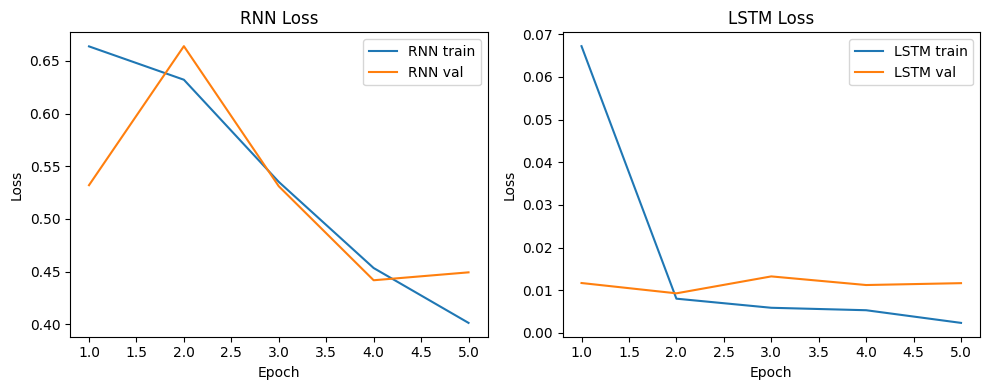

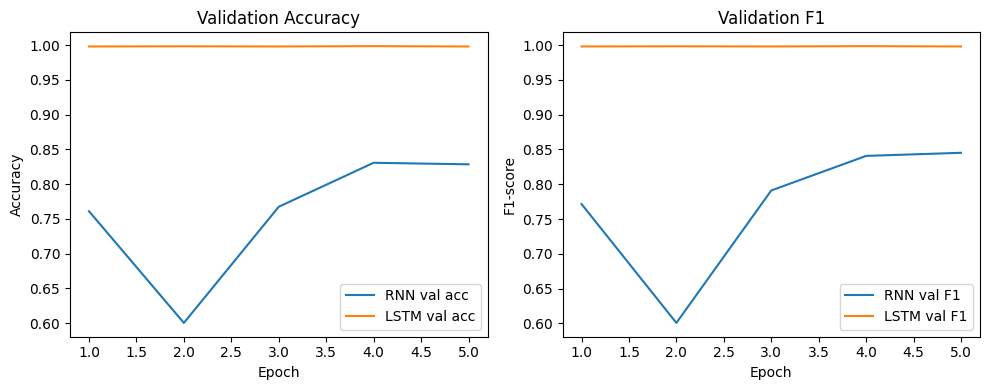

In [6]:
# ===== Plot training/validation loss =====
epochs = range(1, num_epochs + 1)
plt.figure(figsize=(10,4))
plt.subplot(1,2,1)
plt.plot(epochs, rnn_hist['train_loss'], label='RNN train')
plt.plot(epochs, rnn_hist['val_loss'], label='RNN val')
plt.xlabel('Epoch'); plt.ylabel('Loss'); plt.title('RNN Loss'); plt.legend()

plt.subplot(1,2,2)
plt.plot(epochs, lstm_hist['train_loss'], label='LSTM train')
plt.plot(epochs, lstm_hist['val_loss'], label='LSTM val')
plt.xlabel('Epoch'); plt.ylabel('Loss'); plt.title('LSTM Loss'); plt.legend()
plt.tight_layout()
plt.show()

# ===== Plot accuracy/F1 =====
plt.figure(figsize=(10,4))
plt.subplot(1,2,1)
plt.plot(epochs, rnn_hist['val_acc'], label='RNN val acc')
plt.plot(epochs, lstm_hist['val_acc'], label='LSTM val acc')
plt.xlabel('Epoch'); plt.ylabel('Accuracy'); plt.title('Validation Accuracy'); plt.legend()

plt.subplot(1,2,2)
plt.plot(epochs, rnn_hist['val_f1'], label='RNN val F1')
plt.plot(epochs, lstm_hist['val_f1'], label='LSTM val F1')
plt.xlabel('Epoch'); plt.ylabel('F1-score'); plt.title('Validation F1'); plt.legend()
plt.tight_layout()
plt.show()


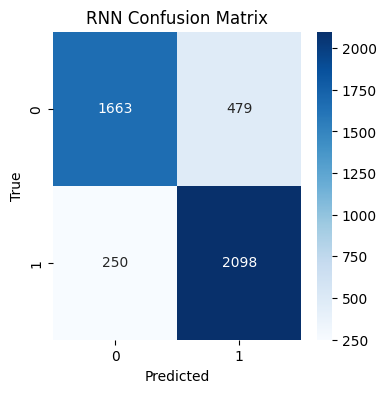

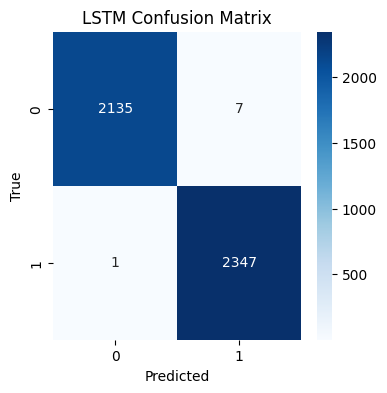

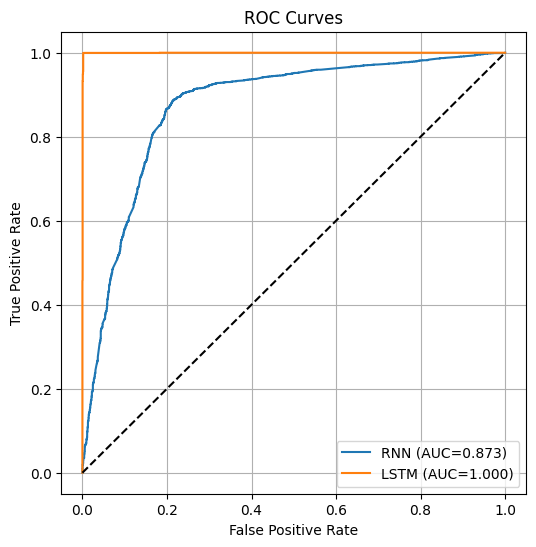

In [7]:
# ===== Confusion matrices on test =====
def plot_confusion(labels, preds, title):
    cm = confusion_matrix(labels, preds)
    plt.figure(figsize=(4,4))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.xlabel('Predicted'); plt.ylabel('True');
    plt.title(title)
    plt.show()

plot_confusion(rnn_test['labels'], rnn_test['preds'], 'RNN Confusion Matrix')
plot_confusion(lstm_test['labels'], lstm_test['preds'], 'LSTM Confusion Matrix')

# ===== ROC curves =====
plt.figure(figsize=(6,6))
plt.plot(rnn_test['fpr'], rnn_test['tpr'], label=f'RNN (AUC={rnn_test["roc_auc"]:.3f})')
plt.plot(lstm_test['fpr'], lstm_test['tpr'], label=f'LSTM (AUC={lstm_test["roc_auc"]:.3f})')
plt.plot([0,1], [0,1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curves')
plt.legend()
plt.grid(True)
plt.show()


In [8]:
results_table = pd.DataFrame([
    {
        'Model': 'Simple RNN',
        'Emb dim': emb_dim,
        'Hidden dim': hidden_dim,
        'Layers': num_layers,
        'Bidirectional': False,
        'Batch size': batch_size,
        'LR': lr,
        'Epochs': num_epochs,
        'Train time (s)': round(rnn_time, 2),
        'Test Acc': rnn_test['acc'],
        'Test Precision': rnn_test['precision'],
        'Test Recall': rnn_test['recall'],
        'Test F1': rnn_test['f1'],
        'ROC AUC': rnn_test['roc_auc']
    },
    {
        'Model': 'BiLSTM',
        'Emb dim': emb_dim,
        'Hidden dim': hidden_dim,
        'Layers': num_layers,
        'Bidirectional': True,
        'Batch size': batch_size,
        'LR': lr,
        'Epochs': num_epochs,
        'Train time (s)': round(lstm_time, 2),
        'Test Acc': lstm_test['acc'],
        'Test Precision': lstm_test['precision'],
        'Test Recall': lstm_test['recall'],
        'Test F1': lstm_test['f1'],
        'ROC AUC': lstm_test['roc_auc']
    }
])

results_table

,Model,Emb dim,Hidden dim,Layers,Bidirectional,Batch size,LR,Epochs,Train time (s),Test Acc,Test Precision,Test Recall,Test F1,ROC AUC
0,Simple RNN,100,128,1,False,64,0.001,5,221.84,0.837639,0.814125,0.893526,0.851980,0.873468
1,BiLSTM,100,128,1,True,64,0.001,5,439.30,0.998218,0.997026,0.999574,0.998299,0.999594
